# HomeWork 12

**DeadLine : 23:59 27 Azar 1399**

**Total points : 100pts**

Import some prerequisites:

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import LinearSVC
import pandas as pd
import seaborn as sn
import os
import time
import skimage.feature as ft

Run this cell for plotting.

In [3]:
def plotter(img_list, r, w, gray, wr, hr, fig_name = None):
    '''
    Plots images' list with its' caption and saves result image if you want.

    Parameters:
        img_list (list): The list of tuples of image and its' caption.
        r (int): The number of row(s).
        w (int): The number of colunm(s).
        gray (bool): The flag for plotting images in grayscale mode.
        wr (int): The width of one figure.
        hr (int): The height of one figure.
        fig_name (str): The name of the image of the plot. if not set this parameter the plot doesn't save.
    '''
    
    plt.rcParams['figure.figsize'] = (wr, hr)
    for i in range(len(img_list)):
        plt.subplot(r, w, i + 1)
        if img_list[i][2] == 'img':
            if gray:
                plt.imshow(img_list[i][0], cmap = 'gray')
            else:
                plt.imshow(img_list[i][0])
            plt.xticks([])
            plt.yticks([])
        elif img_list[i][2] == 'hist':
            plt.bar(np.arange(len(img_list[i][0])), img_list[i][0], color = 'c')
        else:
            raise Exception("Only image or histogram. Use third parameter of tuples in img_list and set it to img or hist.")
        plt.title(img_list[i][1])
    if fig_name is not None:
        plt.savefig(fig_name + '.png')
    plt.show()

Run this cell for plotting evaluation.

In [4]:
from sklearn.metrics import accuracy_score,confusion_matrix
def evaluation(y_test, y_pred, fig_name, title):
    '''
    Prints accuracy and plots confusion matrix and saves result image.

    Parameters:
        y_test (numpy.ndarray) : test labels (ground truth)
        y_pred (numpy.ndarray) : predicted labels 
        fig_name (str): The name of the image of the plot.
        title (str): The caption of the plot.
    '''

    acc = accuracy_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    print('Accuracy for', title, '=', acc * 100)
    df_cm = pd.DataFrame(cm, range(10), range(10))
    plt.figure(figsize = (10, 7))
    sn.set(font_scale = 1.4) # for label size
    sn.heatmap(df_cm , annot = True, annot_kws = {"size" : 16}, fmt = 'g') # font size
    plt.title(title)
    plt.savefig(fig_name + '.png')
    plt.show()

# PART 3

Here is for your helper functions(optional)

In [5]:
import matplotlib.pyplot as plt
from skimage.feature import hog
from skimage import data, exposure
from tqdm import tqdm
from sklearn import svm
from skimage import color

Classify images with HOG.

In [6]:
def classify_hog(x_train, y_train, x_test):
    '''
    Classifies images with HOG.
    
    Parameters:
        x_train(numpy.ndarray) : train data
        y_train(numpy.ndarray) : train labels
        x_test(numpy.ndarray) : test data
        
    outputs:
        predicted_labels(numpy.ndarray): labels that predicted
    '''
    
    x_t = x_train.copy()
    y_t = y_train.copy()
    x_te = x_test.copy()
    predicted_labels = None
    
    #Write your code here
    x_test = [ color.rgb2gray(i) for i in x_te]
    ppc = 8
    hog_images_train = []
    hog_features_train = []
    
    for image in tqdm(x_train):
        fd,hog_image = hog(image, orientations=8, pixels_per_cell=(ppc,ppc),cells_per_block=(3, 3),block_norm= 'L2',visualize=True)
        hog_images_train.append(hog_image)
        hog_features_train.append(fd)
        
    hog_images = []
    hog_features = []
    
    for image in tqdm(x_test):
        fd,hog_image = hog(image, orientations=8, pixels_per_cell=(ppc,ppc),cells_per_block=(3, 3),block_norm= 'L2',visualize=True)
        hog_images.append(hog_image)
        hog_features.append(fd)     

    clf = LinearSVC()
    clf.fit(hog_features_train,y_train)
    y_pred = clf.predict(hog_features)
    return y_pred    

Classify images using shape descriptors.

In [7]:
def find_greater_contour(countors):
    inx=-1
    maxVal=-999999
    i=0
    for i in range(len(countors)):
        area = cv2.contourArea(countors[i])
        if area>maxVal:
            maxVal=area
            inx=i
    return inx

In [8]:
def classify_shape_desc(x_train, y_train, x_test):
    '''
    Classifies images by using shape descriptors.
    
    Parameters:
        x_train(numpy.ndarray) : train data
        y_train(numpy.ndarray) : train labels
        x_test(numpy.ndarray) : test data
        
    outputs:
        predicted_labels(numpy.ndarray): labels that predicted
    '''
    
    x_t = x_train.copy()
    y_t = y_train.copy()
    x_te = x_test.copy()
    predicted_labels = None
    
    #Write your code here
    images_train = []
    
    for image in tqdm(x_train):
        ret, thresh = cv2.threshold(image, 10,255, 0)
        contours, _ = cv2.findContours(thresh,1,1)
        inx=find_greater_contour(contours)
        ellipse=cv2.fitEllipse(contours[inx])
        (x,y), (MA,ma), angle = cv2.fitEllipse(contours[inx])
        a=ma / 2
        b=MA /2
        ecc=np.sqrt(a**2 - b**2) / a
        area = cv2.contourArea(contours[inx])
        hull = cv2.convexHull(contours[inx])
        hull_area = cv2.contourArea(hull)
        solidity = float(area)/hull_area
        x,y,w,h = cv2.boundingRect(contours[inx])
        aspect_ratio = float(w)/h
        images_train.append([ecc,solidity,aspect_ratio])
        
    images_test = []
    
    for image in tqdm(x_test):
        ret, thresh = cv2.threshold(image, 10, 255, 0)
        contours, _ = cv2.findContours(thresh,1,1)
        inx=find_greater_contour(contours)
        ellipse=cv2.fitEllipse(contours[inx])
        (x,y), (MA,ma), angle = cv2.fitEllipse(contours[inx])
        a=ma / 2
        b=MA /2
        ecc=np.sqrt(a**2 - b**2) / a
        area = cv2.contourArea(contours[inx])
        hull = cv2.convexHull(contours[inx])
        hull_area = cv2.contourArea(hull)
        solidity = float(area)/hull_area
        x,y,w,h = cv2.boundingRect(contours[inx])
        aspect_ratio = float(w)/h
        images_test.append([ecc,solidity,aspect_ratio])

    clf = LinearSVC()
    clf.fit(images_train,y_train)
    y_pred = clf.predict(images_test)
    
    return y_pred   

Implement LBP here:

In [9]:
def myLBP(img):
    '''
    Extracts LBP features from the input image.
    
    Parameters:
        img(numpy.ndarray) : image data
    outputs:
        output: LBP features
    '''
    
    input_img = img.copy()
    output = None
    
    #Write your code here
    
    output=np.zeros((26, 26))
    temp = img.copy()
    win_size=3
    size=win_size//2
    power_val = np.matrix([[1, 2, 4], [128, 0,8],[64,32,16]])
    r,c=img.shape
    for i in range(1,r-1):
        for j in range(1,c-1):
            temp=np.zeros((3,3))
            sliced=img[i-1:i+2,j-1:j+2]
            ones=np.where(sliced>sliced[1,1])
            zeros=np.where(sliced<=sliced[1,1])
            temp[ones]=1
            temp[zeros]=0
            output[i-1,j-1]= np.sum(np.multiply(power_val,temp))  

            
           
    return output

In [10]:
def classify_your_lbp(x_train, y_train, x_test):
    '''
    Classifies images by using your LBP.
    
    Parameters:
        x_train(numpy.ndarray) : train data
        y_train(numpy.ndarray) : train labels
        x_test(numpy.ndarray) : test data
        
    outputs:
        predicted_labels(numpy.ndarray): labels that predicted
    '''
    
    x_t = x_train.copy()
    y_t = y_train.copy()
    x_te = x_test.copy()
    predicted_labels = None
    
    #Write your code here
    images_train = []
    features_train = []
    
    for image in tqdm(x_train):
        lbp_temp=myLBP(image)
        hist, _ = np.histogram(lbp_temp, density=True, bins=256, range=(0, 256))
        images_train.append(hist)
        
    images_test = []
    features_test = []
    
    for image in tqdm(x_test):
        lbp_temp=myLBP(image)
        hist, _ = np.histogram(lbp_temp, density=True, bins=256, range=(0, 256))
        images_test.append(hist)
            
            
    clf = LinearSVC()
    clf.fit(images_train,y_train)
    y_pred = clf.predict(images_test)

    return y_pred    

Classify images using Scikit-Image LBP.

In [11]:
def classify_skimage_lbp(x_train, y_train, x_test):
    '''
    Classifies images by using Scikit-Image LBP.
    
    Parameters:
        x_train(numpy.ndarray) : train data
        y_train(numpy.ndarray) : train labels
        x_test(numpy.ndarray) : test data
        
    outputs:
        predicted_labels(numpy.ndarray): labels that predicted
    '''
    
    x_t = x_train.copy()
    y_t = y_train.copy()
    x_te = x_test.copy()
    predicted_labels = None
    
    #Write your code here
    P = 8
    R = 1
    images_train = []
    features_train = []
    
    for image in tqdm(x_train):
        lbp = ft.local_binary_pattern(image, P, R)
        hist, _ = np.histogram(lbp, density=True, bins=256, range=(0, 256))
        images_train.append(hist)
        
    images_test = []
    features_test = []
    
    for image in tqdm(x_test):
        lbp = ft.local_binary_pattern(image, P, R)
        hist, _ = np.histogram(lbp, density=True, bins=256, range=(0, 256))
        images_test.append(hist)
            
    clf = LinearSVC()
    clf.fit(images_train,y_train)
    y_pred = clf.predict(images_test)
    
    return y_pred    

Test your implementation (don't change this cell).

c:\users\zahra\appdata\local\programs\python\python37-32\lib\site-packages\ipykernel_launcher.py:20: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:43<00:00, 230.89it/s]


Accuracy for using HOG = 94.46


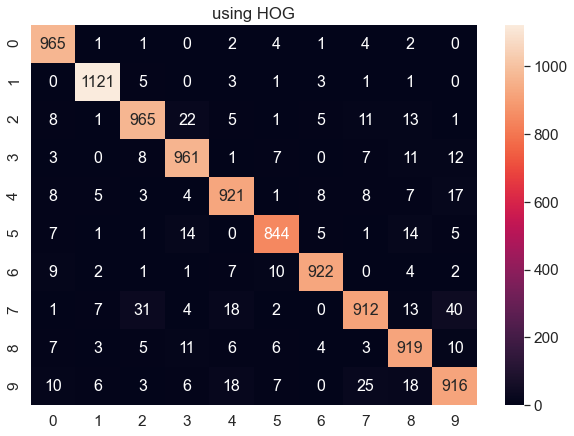

100%|██████████████████████████████████████████████████████████████████████████| 10000/10000 [00:01<00:00, 5315.84it/s]


Accuracy for using shape desacriptots = 42.8


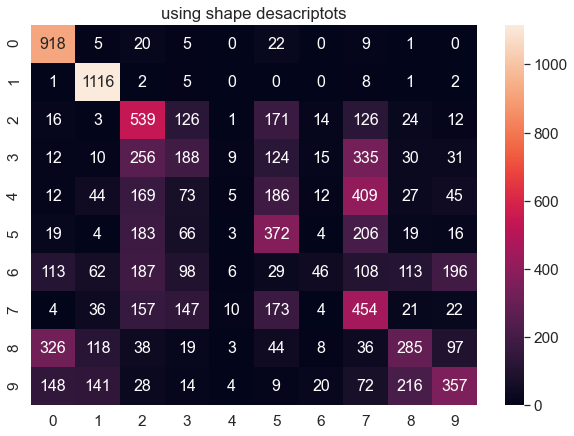

100%|████████████████████████████████████████████████████████████████████████████| 10000/10000 [15:38<00:00, 10.65it/s]


time for your LBP: 5546.413587 s
Accuracy for using your LBP = 70.61


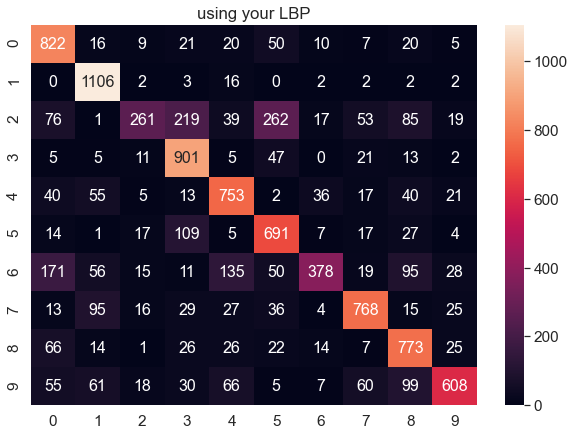

100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:15<00:00, 629.11it/s]


time for Scikit-Image LBP: 119.575590 s
Accuracy for using Scikit-Image LBP = 57.07


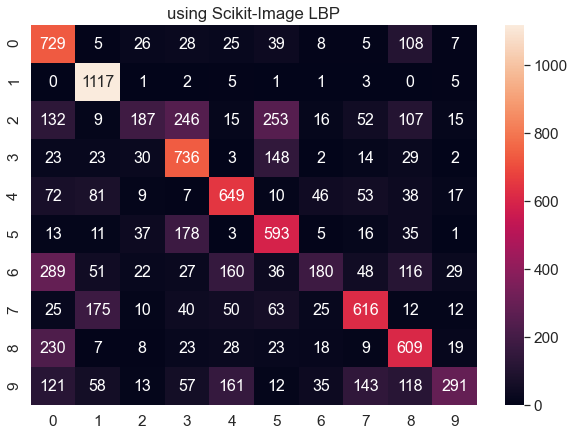

In [12]:
data = np.load('mnist.npz')
[x_train, y_train, x_test, y_test] = data['x_train'], data['y_train'], data['x_test'], data['y_test']
y_pred = classify_hog(x_train, y_train, x_test)
evaluation(y_test, y_pred, '3a', 'using HOG')
y_pred = classify_shape_desc(x_train, y_train, x_test)
evaluation(y_test, y_pred, '3b', 'using shape desacriptots')
t1 = time.time()
y_pred = classify_your_lbp(x_train, y_train, x_test)
t2 = time.time()
print('time for your LBP: %f s' % (t2 - t1))
evaluation(y_test, y_pred, '3c', 'using your LBP')
t1 = time.time()
y_pred = classify_skimage_lbp(x_train, y_train, x_test)
t2 = time.time()
print('time for Scikit-Image LBP: %f s' % (t2 - t1))
evaluation(y_test, y_pred, '3d', 'using Scikit-Image LBP')

# PART 4

#### Use shape and geometrical features to classify two kinds of leaves.

Here is for your helper functions(optional)

Implement your code here.

In [13]:
def classify_leaf(image):
    '''
    Classifies the input image to only two classes of leaves.
    
    Parameters:
        image (numpy.ndarray): The input image.
    
    Returns:
        int: The class of the image. 1 == apple, 0 == linden
    '''
    
    leaf_type = 0
    
    #Write your code here
    img_gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    blur = cv2.GaussianBlur(img_gray,(3,3),0)
    ret, thresh = cv2.threshold(blur, 220, 255, 0)
    
    contours, _ = cv2.findContours(thresh,cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE )
    inx=find_greater_contour(contours)
    

    (x,y), (MA,ma), angle = cv2.fitEllipse(contours[inx])
    a=ma / 2
    b=MA /2
    ecc=np.sqrt(a**2 - b**2) / a

    area = cv2.contourArea(contours[inx])
    hull = cv2.convexHull(contours[inx])
    hull_area = cv2.contourArea(hull)
    solidity = float(area)/hull_area

    x,y,w,h = cv2.boundingRect(contours[inx])
    aspect_ratio = float(w)/h

    area = cv2.contourArea(contours[inx])
    x,y,w,h = cv2.boundingRect(contours[inx])
    rect_area = w*h
    extent = float(area)/rect_area
    
    if solidity == 1:
        if aspect_ratio <0.7 and ecc <0.9:
            if extent > 0.9959:
                return 0
        if ecc <0.5:
            return 0
        else:
            return 1

    return leaf_type

Test your implementation (don't change this cell).

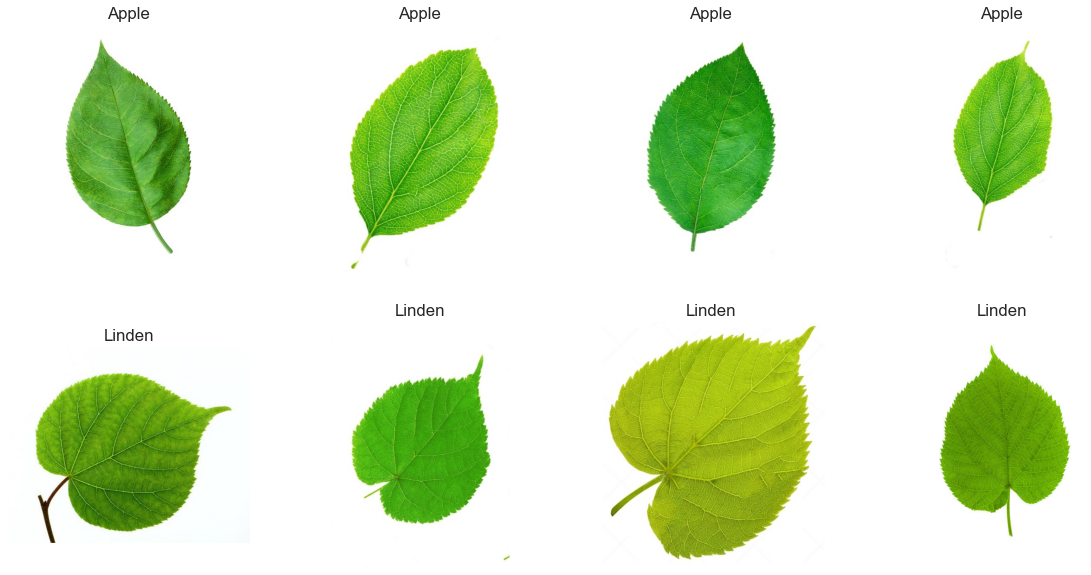

Accuracy is 100.0%


In [17]:
image_list = []
acc = 0
for i in range(1,5):
    image = cv2.imread(os.path.join('images', 'apple', '{}.jpg'.format(i)))
    leaf_type = classify_leaf(image)
    acc += int(leaf_type==1)
    image_list.append([cv2.cvtColor(image, cv2.COLOR_BGR2RGB),'Apple' if leaf_type else 'Linden' , 'img'])
for i in range(1,5):
    image = cv2.imread(os.path.join('images', 'linden', '{}.jpg'.format(i)))
    leaf_type = classify_leaf(image)
    acc += int(leaf_type==0) 
    image_list.append([cv2.cvtColor(image, cv2.COLOR_BGR2RGB),'Apple' if leaf_type else 'Linden' , 'img'])
plotter(image_list, 2, 4, True, 20, 10, '4')
print("Accuracy is {}%".format(acc/0.08))

To create proper files for sending in the Quera run this cell, please.

In [158]:
!python notebook_converter.py

End!!!